In [13]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/home/yuncong/project/cython-munkres-wrapper/build/lib.linux-x86_64-2.7')
from munkres import munkres

import os
import time

from utilities2015 import *

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, single, complete

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.measure import find_contours
from skimage.util import img_as_float

import matplotlib.pyplot as plt
%matplotlib inline

# import cv2

from networkx import from_dict_of_lists, Graph, adjacency_matrix, dfs_postorder_nodes
from networkx.algorithms import node_connected_component

stack_name = 'MD593'

dms = dict([(sec_ind, DataManager(stack=stack_name, section=sec_ind, segm_params_id='gridsize200')) 
       for sec_ind in [67,69]])

In [14]:
def boundary_distance(b1, b2, sc1=None, sc2=None, loc_thresh=1500, verbose=False):
    '''
    Compute the distance between two boundaries.
    Each tuple consists of (edgeSet, interior_texture, exterior_textures, points, center)
    
    Parameters
    ----------
    b1 : tuple
    b2 : tuple
    sc1 : #points-by-32 array
        pre-computed shape context descriptor
    sc2 : #points-by-32 array
        pre-computed shape context descriptor
    '''
    
    _, interior_texture1, exterior_textures1, points1, center1 = b1
    _, interior_texture2, exterior_textures2, points2, center2 = b2
    if sc1 is not None:
        assert len(sc1) == points1.shape[0], 'number mismatch %d %d'%(len(sc1), points1.shape[0])
    
    if sc2 is not None:
        assert len(sc2) == points2.shape[0], 'number mismatch %d %d'%(len(sc2), points2.shape[0])

    # compute location difference
    d_loc = np.linalg.norm(center1 - center2)
    D_loc = np.maximum(0, d_loc - 500)
    
    sys.stderr.write('D_loc computed\n')
#     print 'd_loc', d_loc

    if d_loc > loc_thresh:
        return np.inf, np.inf, np.inf, np.inf, np.inf
    
    n1 = len(points1)
    n2 = len(points2)
    
    if max(n1,n2) > min(n1,n2) * 3:
        return np.inf, np.inf, np.inf, np.inf, np.inf
    
    # compute interior texture difference
    D_int = chi2(interior_texture1, interior_texture2)
#     D_ext = hausdorff_histograms(exterior_textures1, exterior_textures2, metric=chi2)

    sys.stderr.write('D_interior computed\n')

    # compute shape difference, exterior texture difference
    D_shape, matches = shape_context_score(points1, points2, descriptor1=sc1, descriptor2=sc2, verbose=verbose)
#         D_ext = np.mean([chi2(exterior_textures1[i], exterior_textures2[j]) for i, j in matches])
    
    sys.stderr.write('D_shape computed\n')
    
    bg_match = 0

    if len(matches) == 0:
        D_ext = np.inf
    else:
        ddd = []
        for i, j in matches:
            # -1 vs -1
            if np.isnan(exterior_textures1[i]).all() and np.isnan(exterior_textures2[j]).all():
                s = 0
                bg_match += 1
                ddd.append(s)
            # non -1 vs non -1
            elif not np.isnan(exterior_textures1[i]).all() and not np.isnan(exterior_textures2[j]).all():
                s = chi2(exterior_textures1[i], exterior_textures2[j])
                if verbose:
                    print 'exterior', i,j,s
                ddd.append(s)
            # -1 vs non -1
            else:
                ddd.append(2.)

        if len(ddd) == 0:
            D_ext = np.inf
        elif len(ddd) == bg_match:
            D_ext = 2.
        else:
            D_ext = np.mean(ddd)
    
    D_shape = D_shape * .01

    # weighted average of four terms
    d = D_int + D_ext + D_shape + 0 * D_loc
    
    return d, D_int, D_ext, D_shape, D_loc


In [15]:
def rigid_transform_from_pairs(X,Y):
    '''
    X, Y are n-by-2 matrices
    '''
    
    Xcentroid = X.mean(axis=0)
    Ycentroid = Y.mean(axis=0)
    
    Xcentered = X - Xcentroid
    Ycentered = Y - Ycentroid
    
    U, S, V = np.linalg.svd(np.dot(Xcentered.T, Ycentered))
    M = [[1, 0], [0, np.linalg.det(np.dot(V, U.T))]]
    R = np.dot(V, np.dot(M, U.T))
    angle = np.arctan2(R[1,0], R[0,0])
    t = Ycentroid.T - np.dot(R, Xcentroid.T)
    
    T = np.eye(3)
    T[:2, :2] = R
    T[:2, 2] = t
   
    return T, angle

def rigid_transform_to(pts1, T):
    pts1_trans = np.dot(T, np.column_stack([pts1, np.ones((pts1.shape[0],))]).T).T
    pts1_trans = pts1_trans[:,:2]/pts1_trans[:,-1][:,np.newaxis]
    return pts1_trans


In [16]:
def shape_context_score(pts1, pts2, descriptor1=None, descriptor2=None, verbose=False):

    if descriptor1 is None:
        descriptor1 = compute_shape_context_descriptors(pts1, dist_limit=.8)
    
    if descriptor2 is None:
        descriptor2 = compute_shape_context_descriptors(pts2, dist_limit=.8)
        
    descriptor_dists = cdist(descriptor1, descriptor2, metric='euclidean')
        
#     b = time.time()

    T, best_match, best_sample, best_score = ransac_compute_rigid_transform(descriptor_dists, pts1, pts2, 
                                                                            ransac_iters=50, confidence_thresh=0.03, 
                                                                            sample_size=3, matching_iter=10,
                                                                           n_neighbors=3)
#     print 'ransac_compute_rigid_transform', time.time() - b

    
    if T is None and len(best_match)==0:
        return np.inf, []
    
    if verbose:
        print 'best_match', best_match
        print 'best_sample', best_sample
        print 'best_score', best_score

    return best_score, best_match

In [17]:
def euclidean_dists_angles(points):
    """Returns symmetric pairwise ``dists`` and ``angles`` arrays."""
    
    n = len(points)
    dists = squareform(pdist(points, 'euclidean'))

    xd = -np.subtract.outer(points[:,0], points[:,0])
    yd = -np.subtract.outer(points[:,1], points[:,1])
    angles = np.arctan2(yd,xd)

    closest_neighbor = dists.argsort(axis=1)[:,1]
    tangent_vectors = points[closest_neighbor] - points
    tangent_angles = np.arctan2(tangent_vectors[:,1], tangent_vectors[:,0])

    angles = angles - tangent_angles[:, np.newaxis]
    angles = angles%(2*np.pi)
    angles[angles > np.pi] = angles[angles > np.pi] - 2*np.pi

    return dists, angles

def compute_r_theta_bins(n_radial_bins=5, n_polar_bins=12, dist_limit=1.):
    """
    Generate radius-theta bins for the shape context histogram.
    
    Args:
        n_radial_bins (int): number of radial bins
        n_polar_bins (int): number of polar bins
        dist_limit (float): between 0 and 1

    Returns:
        (float array, float array): (r_array, theta_array)

    """
        
    base = 10.    
    r_array = dist_limit * (np.logspace(0, 1, n_radial_bins + 1, base=10) - 1)[1:] / (base-1)
    theta_array = np.linspace(-np.pi, np.pi, n_polar_bins + 1)[1:]
    
    return r_array, theta_array

def compute_shape_context_descriptors(pts, n_radial_bins=5, n_polar_bins=12, 
                                      dist_limit=1., density=True):

    dists, angles = euclidean_dists_angles(pts)
    n_points = dists.shape[0]
    
    r_array, theta_array = compute_r_theta_bins(n_radial_bins, n_polar_bins, dist_limit)
    
    descriptors_mat = np.zeros((n_points, n_radial_bins, n_polar_bins), dtype=np.int)

    dists = dists / dists.max()

    for i in range(n_points):
        for j in range(i + 1, n_points):
            
            if dists[i, j] >= r_array[-1]:
                continue

            r_idx = np.searchsorted(r_array, dists[i, j])
            theta_idx = np.searchsorted(theta_array, angles[i, j])

            descriptors_mat[i, r_idx, theta_idx] += 1

            theta_idx = np.searchsorted(theta_array, angles[j, i])
            descriptors_mat[j, r_idx, theta_idx] += 1

    descriptors = descriptors_mat.reshape(descriptors_mat.shape[0], -1).astype(np.float)

    if density:
        descriptors = descriptors/np.sum(descriptors, axis=1)[:,None]
    
    return descriptors

In [18]:
from skimage.util import pad

def generate_matching_visualizations(sec1, sec2, matchings=None):
    '''
    Generate visualization for matching between sec1 and sec2
    '''
    
    dm1 = dms[sec1]
    dm2 = dms[sec2]
    
    boundaries1 = dm1.load_pipeline_result('boundaryModels')
    boundaries2 = dm2.load_pipeline_result('boundaryModels')
    
    if matchings is None:
        matchings = dm1.load_pipeline_result('matchings%dWith%d'%(sec1, sec2))

    matched_boundaries1 = [boundaries1[i][0] for ind, (d,i,j) in enumerate(matchings)]
    vis_matched_boundaries_next = dm1.visualize_edge_sets(matched_boundaries1, show_set_index=True)

    matched_boundaries2 = [boundaries2[j][0] for ind, (d,i,j) in enumerate(matchings)]
    vis_matched_boundaries_prev = dm2.visualize_edge_sets(matched_boundaries2, show_set_index=True)

    # Place two images vertically 
    h1, w1 = vis_matched_boundaries_next.shape[:2]
    h2, w2 = vis_matched_boundaries_prev.shape[:2]
    
    if w1 < w2:
        left_margin = int((w2 - w1)/2)
        right_margin = w2 - w1 - left_margin
        vis_matched_boundaries_next = pad(vis_matched_boundaries_next, 
                                          ((0,0),(left_margin,right_margin),(0,0)), 
                                          'constant', constant_values=255)
    else:
        left_margin = int((w1 - w2)/2)
        right_margin = w1 - w2 - left_margin
        vis_matched_boundaries_prev = pad(vis_matched_boundaries_prev, 
                                          ((0,0),(left_margin,right_margin),(0,0)), 
                                          'constant', constant_values=255)
        
    vis = np.r_[vis_matched_boundaries_next, vis_matched_boundaries_prev]
    
    return vis
    
#     dm1.save_pipeline_result(vis, 'matchedBoundaries%dWith%dSideBySide'%(sec1, sec2), 'jpg')
#     dm2.save_pipeline_result(vis, 'matchedBoundaries%dWith%dSideBySide'%(sec2, sec1), 'jpg')
    
#     for ind, (s, i, j) in enumerate(matchings):
#         # image with a particular boundary highlighted
        
#         vis1 = dm1.load_pipeline_result('boundary%02d'%i, 'jpg')
#         vis2 = dm2.load_pipeline_result('boundary%02d'%j, 'jpg')
        
#         h1, w1 = vis1.shape[:2]
#         h2, w2 = vis2.shape[:2]
        
#         # Place vertically
#         if w1 < w2:
#             left_margin = int((w2 - w1)/2)
#             right_margin = w2 - w1 - left_margin
#             vis1 = pad(vis1, ((0,0),(left_margin,right_margin),(0,0)), 'constant', constant_values=255)
#         else:
#             left_margin = int((w1 - w2)/2)
#             right_margin = w1 - w2 - left_margin
#             vis2 = pad(vis2, ((0,0),(left_margin,right_margin),(0,0)), 'constant', constant_values=255)

#         vis_pair_prev = np.r_[vis1, vis2]
#         vis_pair_next = np.r_[vis2, vis1]
        
#         dm1.save_pipeline_result(vis_pair_prev, 'matchedBoundaryPair%dFor%dWith%d'%(ind, sec1, sec2), 'jpg')
#         dm2.save_pipeline_result(vis_pair_next, 'matchedBoundaryPair%dFor%dWith%d'%(ind, sec2, sec1), 'jpg')
    

In [7]:
dm1 = dms[67]
dm2 = dms[69]
    
boundaries1 = dm1.load_pipeline_result('boundaryModels')
boundaries2 = dm2.load_pipeline_result('boundaryModels')

sc1 = dm1.load_pipeline_result('shapeContext')
sc2 = dm2.load_pipeline_result('shapeContext')

In [8]:
_, interior_texture1, exterior_textures1, points1, center1 = boundaries1[1]
_, interior_texture2, exterior_textures2, points2, center2 = boundaries2[23]

descriptor_dists = cdist(sc1[1], sc2[23], metric='euclidean')

In [14]:
T, best_match, best_sample, best_score = ransac_compute_rigid_transform(descriptor_dists, points1, points2, 
                                                                            ransac_iters=50, confidence_thresh=0.03, 
                                                                            sample_size=3, matching_iter=10,
                                                                           n_neighbors=3,
                                                                       verbose=True)

high_confidence_pairs [[ 1  0]
 [ 1  2]
 [ 2 11]
 [ 4 11]]
[[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]


n_possible_samples = 4
ri = 0
tt = 0
tt = 1
tt = 2
tt = 3
tt = 4
tt = 5
tt = 6
tt = 7
tt = 8
tt = 9
tt = 10
tt = 11
tt = 12
tt = 13
tt = 14
tt = 15
tt = 16
tt = 17
tt = 18
tt = 19
tt = 20
tt = 21
tt = 22
tt = 23
tt = 24
tt = 25
tt = 26
tt = 27
tt = 28
tt = 29
tt = 30
tt = 31
tt = 32
tt = 33
tt = 34
tt = 35
tt = 36
tt = 37
tt = 38
tt = 39
tt = 40
tt = 41
tt = 42
tt = 43
tt = 44
tt = 45
tt = 46
tt = 47
tt = 48
tt = 49
tt = 50
tt = 51
tt = 52
tt = 53
tt = 54
tt = 55
tt = 56
tt = 57
tt = 58
tt = 59
tt = 60
tt = 61
tt = 62
tt = 63
tt = 64
tt = 65
tt = 66
tt = 67
tt = 68
tt = 69
tt = 70
tt = 71
tt = 72
tt = 73
tt = 74
tt = 75
tt = 76
tt = 77
tt = 78
tt = 79
tt = 80
tt = 81
tt = 82
tt = 83
tt = 84
tt = 85
tt = 86
tt = 87
tt = 88
tt = 89
tt = 90
tt = 91
tt = 92
tt = 93
tt = 94
tt = 95
tt = 96
tt = 97
tt = 98
tt = 99
samples = 0


TypeError: 'NoneType' object is not iterable

In [19]:
from scipy.misc import comb
import random

def ransac_compute_rigid_transform(Dm, pts1, pts2, confidence_thresh=.01, ransac_iters=20, sample_size=5,
                                  matching_iter=10, n_neighbors=10, verbose=False):

#     q = time.time()
    
    high_confidence_thresh = np.sort(Dm.flat)[int(confidence_thresh * np.size(Dm))]
#     print 'high_confidence_thresh', high_confidence_thresh
    
    N1 = len(pts1)
    N2 = len(pts2)
    
    rs, cs = np.where(Dm < high_confidence_thresh)
    high_confidence_pairs = np.c_[rs,cs]
    
    if len(high_confidence_pairs) == 0:
        return None, [], None, np.inf
    
    if verbose:
        print 'high_confidence_pairs', high_confidence_pairs
    
#     from itertools import combinations
#     possible_samples = list(combinations(high_confidence_pairs, sample_size))
#     random.shuffle(possible_samples)
    
#     n_possible_samples = len([t for t in combinations(high_confidence_pairs, sample_size) 
#                         if allunique([tt[0] for tt in t]) and allunique([tt[1] for tt in t])])
#     print 'n_possible_samples', len(possible_samples)
#     random.shuffle(possible_samples)

#     print 'comb', time.time() - q

#     return
    
    p1s = np.sort(list(set(rs)))
    p2s = np.sort(list(set(cs)))
    n1 = len(p1s)
    n2 = len(p2s)
    
    if n1 < sample_size or n2 < sample_size:
        return None, [], None, np.inf
    
    offsets = []
    scores = []
    matches_list = []
    samples_list = []
    
    sample_counter = 0
    n_possible_samples = int(comb(len(high_confidence_pairs), sample_size, exact=False))

    if verbose:
        sys.stderr.write('n_possible_samples = %d\n' % n_possible_samples)
    
#     n_possible_samples = len(possible_samples)
    for ri in range(min(ransac_iters, n_possible_samples)):
        sys.stderr.write('ri = %d\n' % ri)

        samples = []
        
        for tt in range(100):
            sys.stderr.write('tt = %d\n' % tt)

#             s = possible_samples[sample_counter]
            s = random.sample(high_confidence_pairs, sample_size)
            sample_counter += 1
            w1, w2 = zip(*s)
            if len(set(w1)) == len(w1) and len(set(w2)) == len(w2):
                samples = s
                break
                
        if len(samples) == 0:
            continue
            
#         samples = np.array(possible_samples[ri])

        if verbose:
            sys.stderr.write('samples = %d\n' % ri)
#             print '\nsamples', ri, samples
        
        X = pts1[[s[0] for s in samples]]
        Y = pts2[[s[1] for s in samples]]
                
        # generate transform hypothesis
        T, angle = rigid_transform_from_pairs(X, Y)
        if np.abs(angle) > np.pi/4:
            if verbose:
                print 'angle too wide', np.rad2deg(angle)
            continue
        
        # apply transform hypothesis
        pts1_trans = rigid_transform_to(pts1, T)
        
        # iterative closest point association
        matches = None
        matches_prev = None
        
        for mi in range(matching_iter):
  
            # given transform, find matching

#             t1 = time.time()
        
#             b = time.time()
    
            Dh = cdist(pts1_trans, pts2, metric='euclidean')
            Dargmin1 = Dh.argsort(axis=1)
            Dargmin0 = Dh.argsort(axis=0)
#             print 'cdist', time.time() - b
        
#             b = time.time()
            
            D2 = Dh.copy()
            D2[np.arange(N1)[:,np.newaxis], Dargmin1[:,n_neighbors:]] = 999
            D2[Dargmin0[n_neighbors:,:], np.arange(N2)[np.newaxis,:]] = 999
            D_hc_pairs = D2[p1s[:,np.newaxis], p2s]
                
#             D_hc_pairs = 9999 * np.ones((n1, n2))
#             for i,j in high_confidence_pairs:
#                 if j in Dargmin1[i,:10] and i in Dargmin0[:10,j]:
#                     ii = p1s.index(i)
#                     jj = p2s.index(j)
#                     D_hc_pairs[ii, jj] = Dh[i,j]

#             print 'D_hc_pairs', time.time() - b

            if matches is not None:
                matches_prev = matches
        
#             b = time.time()
            matches_hc_pairs = np.array(zip(*np.nonzero(munkres(D_hc_pairs))))
#             print 'munkres', time.time() - b, mi
            
#             b = time.time()

#                 print [(p1s[ii], p2s[jj]) for (ii,jj) in matches_hc_pairs]
            matches = np.array([(p1s[ii], p2s[jj]) for (ii,jj) in matches_hc_pairs
                                if D_hc_pairs[ii, jj] != 999])
            # some 9999 edges will be included, the "if" above removes them
#             print 'matches', time.time() - b
        
            expanded_matches = []
            matches1 = set([i for i,j in matches])
            matches2 = set([j for i,j in matches])
            rem1 = set(range(N1)) - matches1
            rem2 = set(range(N2)) - matches2
            add1 = set([])
            add2 = set([])
            for i in rem1:
                for j in rem2:
                    if j in Dargmin1[i,:3] and i in Dargmin0[:3,j] and i not in add1 and j not in add2:
                        add1.add(i)
                        add2.add(j)
                        expanded_matches.append((i,j))

            if len(expanded_matches) > 0 and len(matches) > 0 :
                matches = np.vstack([matches, np.array(expanded_matches)])
    
            if verbose:
#                 print 'considered pairs', w
#                 print 'matches', [(i,j) for i,j in matches
                q1, q2 = np.where(D_hc_pairs < 999)
                w = zip(*[p1s[q1], p2s[q2]])
                print 'matches', len(matches), '/', 'considered pairs', len(w), '/', 'all hc pairs', len(high_confidence_pairs)

#             t2 = time.time()
            
            if len(matches) < 3:
                s = np.inf
                break
            else:
                xs1 = pts1_trans[matches[:,0], 0]
                x_coverage1 = float(xs1.max() - xs1.min()) / (pts1_trans[:,0].max() - pts1_trans[:,0].min())
                ys1 = pts1_trans[matches[:,0], 1]
                y_coverage1 = float(ys1.max() - ys1.min()) / (pts1_trans[:,1].max() - pts1_trans[:,1].min())
                
                xs2 = pts2[matches[:,1], 0]
                x_coverage2 = float(xs2.max() - xs2.min())/ (pts2[:,0].max() - pts2[:,0].min())
                ys2 = pts2[matches[:,1], 1]
                y_coverage2 = float(ys2.max() - ys2.min())/ (pts2[:,1].max() - pts2[:,1].min())
                
                coverage = .5 * x_coverage1 * y_coverage1 + .5 * x_coverage2 * y_coverage2
                
                s = Dh[matches[:,0], matches[:,1]].mean() / coverage**2    
#             s = .5 * Dm[Dh.argmin(axis=0), np.arange(len(pts2))].mean() + .5 * Dm[np.arange(len(pts1)), Dh.argmin(axis=1)].mean()            
#             s = np.mean([np.mean(Dh.min(axis=0)), np.mean(Dh.min(axis=1))])
    
            X = pts1[matches[:,0]]
            Y = pts2[matches[:,1]]

            T, angle = rigid_transform_from_pairs(X, Y)
            if np.abs(angle) > np.pi/4:
                break

            pts1_trans = rigid_transform_to(pts1, T)
            
            if matches_prev is not None and all([(i,j) in matches_prev for i,j in matches]):
                break
                
#             print 'coverage and remaining', mi, time.time() - t2
        
#             print mi, time.time() - t1
                
#         Dh = cdist(pts1_trans, pts2, metric='euclidean')
#         Dargmin1 = Dh.argsort(axis=1)
#         Dargmin0 = Dh.argsort(axis=0)
        
#         expanded_matches = []
#         matches1 = set([i for i,j in matches])
#         matches2 = set([j for i,j in matches])
#         rem1 = set(range(N1)) - matches1
#         rem2 = set(range(N2)) - matches2
#         add1 = set([])
#         add2 = set([])
#         for i in rem1:
#             for j in rem2:
#                 if j in Dargmin1[i,:3] and i in Dargmin0[:3,j] and i not in add1 and j not in add2:
#                     add1.add(i)
#                     add2.add(j)
#                     expanded_matches.append((i,j))
                    
#         if len(expanded_matches) > 0 and len(matches) > 0 :
#             matches = np.vstack([matches, np.array(expanded_matches)])
        
#         print matches
                            
        samples_list.append(samples)
        offsets.append(T)
        matches_list.append(matches)
        scores.append(s)
    
#         print matches
#         print s
#         plot_two_pointsets(pts1_trans[:,::-1]*np.array([1,-1]), pts2[:,::-1]*np.array([1,-1]), 
#                    center1=False, center2=False,
#                    text=True, matchings=matches)
            
    if len(scores) > 0:
        best_i = np.argmin(scores)

        best_score = scores[best_i]
        best_T = offsets[best_i]
        best_sample = samples_list[best_i]
        best_matches = matches_list[best_i]    
    
        return best_T, best_matches, best_sample, best_score
    else:
        return None, [], None, np.inf


In [21]:
res = boundary_distance(boundaries1[1], boundaries2[23], sc1=sc1[1], sc2=sc2[23], verbose=True)

D_loc computed
D_interior computed
ri = 0
tt = 0
tt = 1
tt = 2
tt = 3
tt = 4
tt = 5
tt = 6
tt = 7
tt = 8
tt = 9
tt = 10
tt = 11
tt = 12
tt = 13
tt = 14
tt = 15
tt = 16
tt = 17
tt = 18
tt = 19
tt = 20
tt = 21
tt = 22
tt = 23
tt = 24
tt = 25
tt = 26
tt = 27
tt = 28
tt = 29
tt = 30
tt = 31
tt = 32
tt = 33
tt = 34
tt = 35
tt = 36
tt = 37
tt = 38
tt = 39
tt = 40
tt = 41
tt = 42
tt = 43
tt = 44
tt = 45
tt = 46
tt = 47
tt = 48
tt = 49
tt = 50
tt = 51
tt = 52
tt = 53
tt = 54
tt = 55
tt = 56
tt = 57
tt = 58
tt = 59
tt = 60
tt = 61
tt = 62
tt = 63
tt = 64
tt = 65
tt = 66
tt = 67
tt = 68
tt = 69
tt = 70
tt = 71
tt = 72
tt = 73
tt = 74
tt = 75
tt = 76
tt = 77
tt = 78
tt = 79
tt = 80
tt = 81
tt = 82
tt = 83
tt = 84
tt = 85
tt = 86
tt = 87
tt = 88
tt = 89
tt = 90
tt = 91
tt = 92
tt = 93
tt = 94
tt = 95
tt = 96
tt = 97
tt = 98
tt = 99
ri = 1
tt = 0
tt = 1
tt = 2
tt = 3
tt = 4
tt = 5
tt = 6
tt = 7
tt = 8
tt = 9
tt = 10
tt = 11
tt = 12
tt = 13
tt = 14
tt = 15
tt = 16
tt = 17
tt = 18
tt = 19
tt = 20
tt 

In [20]:
def compute_boundary_distances(sec1, sec2, verbose=False):
    
    dm1 = dms[sec1]
    dm2 = dms[sec2]
    
    boundaries1 = dm1.load_pipeline_result('boundaryModels')
    boundaries2 = dm2.load_pipeline_result('boundaryModels')
    
    sc1 = dm1.load_pipeline_result('shapeContext')
    sc2 = dm2.load_pipeline_result('shapeContext')

    n_boundaries1 = len(boundaries1)
    n_boundaries2 = len(boundaries2)
    
#     Ds = Parallel(n_jobs=16)(delayed(boundary_distance)(boundaries1[i], boundaries2[j], sc1=sc1[i], sc2=sc2[j]) 
#                              for i, j in product(range(n_boundaries1), range(n_boundaries2)))

    center_dist_thresh = 1500
    
    centers1 = [b[4] for b in boundaries1]
    centers2 = [b[4] for b in boundaries2]
    center_distances = cdist(centers1, centers2, metric='euclidean')
    b1s, b2s = np.where(center_distances < center_dist_thresh)
    
#     b = time.time()

    Ds = []
    for i, j in zip(b1s, b2s):
        sys.stderr.write('%d,%d\n'%(i,j))
        d = boundary_distance(boundaries1[i], boundaries2[j], sc1=sc1[i], sc2=sc2[j], verbose=verbose)
        Ds.append(d)

#     Ds = Parallel(n_jobs=16)(delayed(boundary_distance)(boundaries1[i], boundaries2[j], 
#                                                         sc1=sc1[i], sc2=sc2[j], verbose=verbose) 
#                              for i, j in zip(b1s, b2s))
#     print  'boundary_distance', time.time() - b
    
    D_boundaries = np.inf * np.ones((n_boundaries1, n_boundaries2))
    D_int = np.inf * np.ones((n_boundaries1, n_boundaries2))
    D_ext = np.inf * np.ones((n_boundaries1, n_boundaries2))
    D_shape = np.inf * np.ones((n_boundaries1, n_boundaries2))
    
    D_boundaries[b1s, b2s] = [d for d, d_int, d_ext, d_shape, d_loc in Ds]
    D_int[b1s, b2s] = [d_int for d, d_int, d_ext, d_shape, d_loc in Ds]
    D_ext[b1s, b2s] = [d_ext for d, d_int, d_ext, d_shape, d_loc in Ds]
    D_shape[b1s, b2s] = [d_shape for d, d_int, d_ext, d_shape, d_loc in Ds]
    
#     Ds = []
#     for i, j in product(range(n_boundaries1), range(n_boundaries2)):
#         sys.stderr.write('%d,%d\n'%(i,j))
#         Ds.append(boundary_distance(boundaries1[i], boundaries2[j], sc1=sc1[i], sc2=sc2[j]))

#     D_boundaries, D_int, D_ext, D_shape, D_loc = zip(*Ds)

#     D_boundaries = np.reshape(D_boundaries, (n_boundaries1, n_boundaries2))
#     D_int = np.reshape(D_int, (n_boundaries1, n_boundaries2))
#     D_ext = np.reshape(D_ext, (n_boundaries1, n_boundaries2))
#     D_shape = np.reshape(D_shape, (n_boundaries1, n_boundaries2))
#     D4 = np.reshape(D_loc, (n_boundaries1, n_boundaries2))
    
#     dm1.save_pipeline_result(D_boundaries, 'DBoundaries%dWith%d'%(sec1, sec2), 'npy')
#     dm1.save_pipeline_result(D_int, 'D1s%dWith%d'%(sec1, sec2), 'npy')
#     dm1.save_pipeline_result(D_ext, 'D2s%dWith%d'%(sec1, sec2), 'npy')
#     dm1.save_pipeline_result(D_shape, 'D3s%dWith%d'%(sec1, sec2), 'npy')

    return D_boundaries, D_int, D_ext, D_shape
    
#     dm2.save_pipeline_result(D_boundaries.T, 'DBoundaries%dWith%d'%(sec2, sec1), 'npy')
#     dm2.save_pipeline_result(D_int.T, 'D1s%dWith%d'%(sec2, sec1), 'npy')
#     dm2.save_pipeline_result(D_ext.T, 'D2s%dWith%d'%(sec2, sec1), 'npy')
#     dm2.save_pipeline_result(D_shape.T, 'D3s%dWith%d'%(sec2, sec1), 'npy')


In [21]:
def compute_shape_context_descriptors_section(sec_ind):
    dm = DataManager(stack=stack_name, section=sec_ind, segm_params_id='gridsize200')
    boundaries = dm.load_pipeline_result('boundaryModels', 'pkl')
    descs = [compute_shape_context_descriptors(b[3], dist_limit=.8) for b in boundaries]
    dm.save_pipeline_result(descs, 'shapeContext', 'pkl')
#     return descs

In [22]:
import random

def stable(rankings, A, B):
    partners = dict((a, (rankings[(a, 1)], 1)) for a in A)
    is_stable = False # whether the current pairing (given by `partners`) is stable
    while is_stable == False:
        is_stable = True
        for b in B:
            is_paired = False # whether b has a pair which b ranks <= to n
            for n in range(1, len(B) + 1):
                a = rankings[(b, n)]
                a_partner, a_n = partners[a]
                if a_partner == b:
                    if is_paired:
                        is_stable = False
                        partners[a] = (rankings[(a, a_n + 1)], a_n + 1)
                    else:
                        is_paired = True
    return sorted((a, b) for (a, (b, n)) in partners.items())


def stable_marriage_matchings(D_boundaries):

    A = ['A'+str(i) for i in range(n_boundaries1)]
    B = ['B'+str(i) for i in range(n_boundaries2)]

    ao = np.zeros(D_boundaries)
    for q in range(n_boundaries1):
        ao[q, np.argsort(D_boundaries[q,:])] = np.arange(n_boundaries2)

    bo = np.zeros_like(D_boundaries.T)
    for q in range(n_boundaries2):
        bo[q, np.argsort(D_boundaries[:,q])] = np.arange(n_boundaries1)

    rankings1 = zip(A, ao+1)
    rankings2 = zip(B, bo+1)
    rank = dict(rankings1+rankings2)

    Arankings = dict(((a, rank[a][b_]), B[b_]) for (a, b_) in product(A, range(n_boundaries2)))
    Brankings = dict(((b, rank[b][a_]), A[a_]) for (b, a_) in product(B, range(n_boundaries1)))
    rankings = Arankings
    rankings.update(Brankings)

    m = stable(rankings, A, B)
    m = [(int(i[1:]), int(j[1:])) for i, j in m]
    m = sorted([(D_boundaries[i,j], i,j) for i,j in m if D_boundaries[i,j]<np.inf])

#     for s, i,j in m:
#         print s, i, j
    
    return m

def greedy_matching(D_boundaries, thresh_percentage=.2, verified_matchings=[], excluded_matchings=[]):
    
    Dnz = D_boundaries[D_boundaries < np.inf]
    if len(Dnz) == 0:
        return []
    
    th = np.sort(Dnz.flat)[int(len(Dnz.flat)*thresh_percentage)]
    print 'thresh', th
    
    matchings = [(0,i,j) for i,j in verified_matchings]
    rs, cs = np.unravel_index(np.argsort(D_boundaries.flat), D_boundaries.shape)
    for r, c in zip(rs, cs):
        if (r,c) in excluded_matchings:
            continue
        if D_boundaries[r,c] > th:
            break
        if r not in [i for d,i,j in matchings] and c not in [j for d,i,j in matchings]:
            matchings.append((D_boundaries[r,c],r,c))
            
    return matchings

from collections import defaultdict

def knn_matching(D_boundaries, boundaries1, boundaries2, k=2, centroid_dist_limit=500):
    
    import networkx as nx
    
    n_boundaries1, n_boundaries2 = D_boundaries.shape

    nn1 = D_boundaries.argsort(axis=1)
    dd1 = np.sort(D_boundaries,axis=1)
    nn1 = [nn[:np.searchsorted(d, d[0]+0.2)] for d, nn in zip(dd1, nn1)]
    
    nn2 = D_boundaries.argsort(axis=0).T
    dd2 = np.sort(D_boundaries,axis=0).T
    nn2 = [nn[:np.searchsorted(d, d[0]+0.2)] for d, nn in zip(dd2, nn2)]

    DD = np.zeros((n_boundaries1+n_boundaries2, n_boundaries1+n_boundaries2))
    G = nx.Graph(DD)
    G = nx.relabel_nodes(G, dict([(i,(0,i)) for i in range(n_boundaries1)]+[(n_boundaries1+j,(1,j)) for j in range(n_boundaries2)]))
    matches = []
    for i in range(n_boundaries1):
        for j in range(n_boundaries2):
#             if j in nn1[i,:k] and i in nn2[j,:k]:
            if j in nn1[i] and i in nn2[j]:
                matches.append((i,j))
                G.add_edge((0,i), (1,j))

    ms = [sorted(g) for g in sorted(list(nx.connected_components(G)), key=len, reverse=True) if len(g) >= 2]
#     print len(ms), 'matchings'
    
    groups = []
    for mi, m in enumerate(ms):
        d = defaultdict(list)
        for sec_i, bnd_i in m:
            d[sec_i].append(bnd_i)
        A = D_boundaries[d[0]][:,d[1]]
        rs, cs = np.unravel_index(np.argsort(D_boundaries[d[0]][:,d[1]].flat), (len(d[0]), len(d[1])))
    #     print rs, cs
    #     print [((sec1, d[sec1][r]), (sec2, d[sec2][c]), D_boundaries[d[sec1][r], d[sec2][c]]) for r, c in zip(rs, cs)
    #           if D_boundaries[d[sec1][r], d[sec2][c]] < np.inf]

        g = []
        for r, c in zip(rs, cs):
            if D_boundaries[d[0][r], d[1][c]] < np.inf:
    #             print ((sec1, d[sec1][r]), (sec2, d[sec2][c]), D_boundaries[d[sec1][r], d[sec2][c]])
                g.append([d[0][r], d[1][c]])

        groups.append(g)

    #     print '\n'
    
    boundary1_centers = np.array([b[4][::-1] for b in boundaries1])
    boundary2_centers = np.array([b[4][::-1] for b in boundaries2])

    matches = []
    scores = []

    for ransac_iter in range(5000):

        boundary_samples = [random.sample(g, 1)[0] for g in random.sample(groups, 3)]
        X = []
        Y = []
        for b1, b2 in boundary_samples:
            X.append(boundary1_centers[b1])
            Y.append(boundary2_centers[b2])
        X = np.array(X)
        Y = np.array(Y)

        T, angle = rigid_transform_from_pairs(X,Y)
    #     print T, angle
        if angle > np.pi/2:
    #         print 'angle too wide'
            matches.append([])
            scores.append(0)
            continue

        boundary1_centers_trans = rigid_transform_to(boundary1_centers, T)

        match = [(bi,bj) for g in groups for bi,bj in g 
                 if np.linalg.norm(boundary1_centers_trans[bi] - boundary2_centers[bj]) < centroid_dist_limit]

        score = len(match)

        matches.append(match)
        scores.append(score)

    best = np.argmax(scores)
    s_best = scores[best]
    m_best = matches[best]

    g = nx.Graph()
    g.add_edges_from([((0, i),(1, j), {'weight': D_boundaries[D_boundaries!=np.inf].max()-D_boundaries[i,j]}) 
                      for i,j in m_best])
    m = nx.matching.max_weight_matching(g, maxcardinality=True)
    
    best_match = set(((0, dict([n1,n2])[0]), (1, dict([n1,n2])[1])) for n1,n2 in m.iteritems())
    best_match = [(D_boundaries[t1[1],  t2[1]], t1[1], t2[1]) for t1,t2 in best_match]

    return best_match

def match_landmarks(sec1, sec2, D=None, must_match=[], cannot_match=[]):
    
    dm1 = dms[sec1]
    dm2 = dms[sec2]
    boundaries1 = dm1.load_pipeline_result('boundaryModels')
    boundaries2 = dm2.load_pipeline_result('boundaryModels')
    
    if D is None:
        D = dm1.load_pipeline_result('DBoundaries%dWith%d'%(sec1, sec2))
        
    matchings = knn_matching(D, boundaries1, boundaries2)
    matchings = sorted(matchings)
    
    return matchings

In [23]:
first_sec = 60
last_sec = 150

In [24]:
Parallel(n_jobs=16)(delayed(compute_shape_context_descriptors_section)(sec_ind) 
                    for sec_ind in range(first_sec, last_sec+1));

saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0073/MD593_0073_lossless_gabor-blueNisslWide-segm-gridsize200-vq-blueNissl_shapeContext.pkl
saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0069/MD593_0069_lossless_gabor-blueNisslWide-segm-gridsize200-vq-blueNissl_shapeContext.pkl
saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0062/MD593_0062_lossless_gabor-blueNisslWide-segm-gridsize200-vq-blueNissl_shapeContext.pkl
saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0074/MD593_0074_lossless_gabor-blueNisslWide-segm-gridsize200-vq-blueNissl_shapeContext.pkl
saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0071/MD593_0071_lossless_gabor-blueNisslWide-segm-gridsize200-vq-blueNissl_shapeContext.pkl
saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0070/MD593_0070_lossless_gabor-blueNisslWide-segm-gridsize200-vq-blueNissl_shapeContext.pkl
saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results

In [ ]:
sec1 = 67
sec2 = sec1 + 2

D_boundaries, D_int, D_ext, D_shape = compute_boundary_distances(sec1, sec2, verbose=False)
# matchings = match_landmarks(sec1, sec2, D=D_boundaries)
# viz = generate_matching_visualizations(sec1, sec2, matchings=matchings)

# dms[sec1].save_pipeline_result(D_boundaries, 'DBoundariesNext1')
# dms[sec1].save_pipeline_result(matchings, 'matchingsNext1')
# dms[sec1].save_pipeline_result(viz, 'matchingsVizNext1')

# dms[sec2].save_pipeline_result(D_boundaries.T, 'DBoundariesPrev1')
# matchings = [(d,j,i) for d,i,j in matchings]
# dms[sec2].save_pipeline_result(matchings, 'matchingsPrev1')
# dms[sec2].save_pipeline_result(viz, 'matchingsVizPrev1')

0,0
0,2
0,4
0,7
0,10
0,17
0,22
0,24
0,25
0,26
0,33
0,43
0,45
1,19
1,23


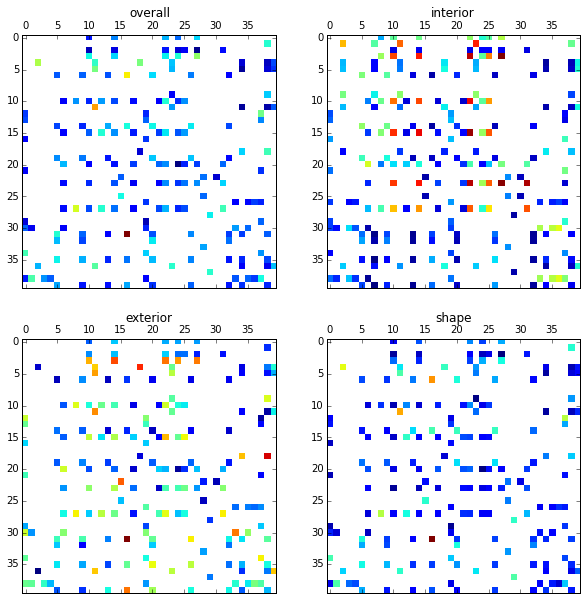

In [82]:
fig, axes = plt.subplots(2,2,figsize=(10,10));

axes[0,0].matshow(D_boundaries);
axes[0,0].set_title('overall');
# axes[0,0].axis('off');
axes[0,1].matshow(D_int);
axes[0,1].set_title('interior');
# axes[0,1].axis('off');
axes[1,0].matshow(D_ext);
axes[1,0].set_title('exterior');
# axes[1,0].axis('off');
axes[1,1].matshow(D_shape);
axes[1,1].set_title('shape');
# axes[1,1].axis('off');

plt.show();

In [120]:
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [114]:
def f(sec1):
    if sec1 < last_sec:
        sec2 = sec1 + 1
        D_boundaries, D_int, D_ext, D_shape = compute_boundary_distances(sec1, sec2, verbose=False)
        matchings = match_landmarks(sec1, sec2, D=D_boundaries)
        viz = generate_matching_visualizations(sec1, sec2, matchings=matchings)
        dms[sec1].save_pipeline_result(D_boundaries, 'DBoundariesNext1')
        dms[sec1].save_pipeline_result(matchings, 'matchingsNext1')
        dms[sec1].save_pipeline_result(viz, 'matchingsVizNext1')
        dms[sec2].save_pipeline_result(D_boundaries, 'DBoundariesPrev1')
        dms[sec2].save_pipeline_result(matchings, 'matchingsPrev1')
        dms[sec2].save_pipeline_result(viz, 'matchingsVizPrev1')
    sys.stderr.write('%d,%d\n'%(sec_ind, sec_ind+1))
    
    if sec1 < last_sec-1:
        sec2 = sec1 + 2
        D_boundaries, D_int, D_ext, D_shape = compute_boundary_distances(sec1, sec2, verbose=False)
        matchings = match_landmarks(sec1, sec2, D=D_boundaries)
        viz = generate_matching_visualizations(sec1, sec2, matchings=matchings)
        dms[sec1].save_pipeline_result(D_boundaries, 'DBoundariesNext2')
        dms[sec1].save_pipeline_result(matchings, 'matchingsNext2')
        dms[sec1].save_pipeline_result(viz, 'matchingsVizNext2')
        dms[sec2].save_pipeline_result(D_boundaries, 'DBoundariesPrev2')
        dms[sec2].save_pipeline_result(matchings, 'matchingsPrev2')
        dms[sec2].save_pipeline_result(viz, 'matchingsVizPrev2')
    sys.stderr.write('%d,%d\n'%(sec_ind, sec_ind+2))
    
    if sec1 < last_sec-2:
        sec2 = sec1 + 3
        D_boundaries, D_int, D_ext, D_shape = compute_boundary_distances(sec1, sec2, verbose=False)
        matchings = match_landmarks(sec1, sec2, D=D_boundaries)
        viz = generate_matching_visualizations(sec1, sec2, matchings=matchings)
        dms[sec1].save_pipeline_result(D_boundaries, 'DBoundariesNext3')
        dms[sec1].save_pipeline_result(matchings, 'matchingsNext3')
        dms[sec1].save_pipeline_result(viz, 'matchingsVizNext3')
        dms[sec2].save_pipeline_result(D_boundaries, 'DBoundariesPrev3')
        dms[sec2].save_pipeline_result(matchings, 'matchingsPrev3')
        dms[sec2].save_pipeline_result(viz, 'matchingsVizPrev3')
    sys.stderr.write('%d,%d\n'%(sec_ind, sec_ind+3))

In [ ]:
Parallel(n_jobs=16)(delayed(f)(sec1) for sec1 in range(first_sec, last_sec+1))

In [ ]:
b = time.time()

for sec1 in range(first_sec, last_sec+1):
    
    if sec1 < last_sec:
        sec2 = sec1 + 1
        D_boundaries, D_int, D_ext, D_shape = compute_boundary_distances(sec1, sec2, verbose=False)
        matchings = match_landmarks(sec1, sec2, D=D_boundaries)
        viz = generate_matching_visualizations(sec1, sec2, matchings=matchings)
        dms[sec1].save_pipeline_result(D_boundaries, 'DBoundariesNext1')
        dms[sec1].save_pipeline_result(matchings, 'matchingsNext1')
        dms[sec1].save_pipeline_result(viz, 'matchingsVizNext1')
        dms[sec2].save_pipeline_result(D_boundaries, 'DBoundariesPrev1')
        dms[sec2].save_pipeline_result(matchings, 'matchingsPrev1')
        dms[sec2].save_pipeline_result(viz, 'matchingsVizPrev1')
    sys.stderr.write('%d,%d\n'%(sec_ind, sec_ind+1))
    
    if sec1 < last_sec-1:
        sec2 = sec1 + 2
        D_boundaries, D_int, D_ext, D_shape = compute_boundary_distances(sec1, sec2, verbose=False)
        matchings = match_landmarks(sec1, sec2, D=D_boundaries)
        viz = generate_matching_visualizations(sec1, sec2, matchings=matchings)
        dms[sec1].save_pipeline_result(D_boundaries, 'DBoundariesNext2')
        dms[sec1].save_pipeline_result(matchings, 'matchingsNext2')
        dms[sec1].save_pipeline_result(viz, 'matchingsVizNext2')
        dms[sec2].save_pipeline_result(D_boundaries, 'DBoundariesPrev2')
        dms[sec2].save_pipeline_result(matchings, 'matchingsPrev2')
        dms[sec2].save_pipeline_result(viz, 'matchingsVizPrev2')
    sys.stderr.write('%d,%d\n'%(sec_ind, sec_ind+2))
    
    if sec1 < last_sec-2:
        sec2 = sec1 + 3
        D_boundaries, D_int, D_ext, D_shape = compute_boundary_distances(sec1, sec2, verbose=False)
        matchings = match_landmarks(sec1, sec2, D=D_boundaries)
        viz = generate_matching_visualizations(sec1, sec2, matchings=matchings)
        dms[sec1].save_pipeline_result(D_boundaries, 'DBoundariesNext3')
        dms[sec1].save_pipeline_result(matchings, 'matchingsNext3')
        dms[sec1].save_pipeline_result(viz, 'matchingsVizNext3')
        dms[sec2].save_pipeline_result(D_boundaries, 'DBoundariesPrev3')
        dms[sec2].save_pipeline_result(matchings, 'matchingsPrev3')
        dms[sec2].save_pipeline_result(viz, 'matchingsVizPrev3')
    sys.stderr.write('%d,%d\n'%(sec_ind, sec_ind+3))
        
print time.time() - b

In [55]:
must_matches = []

must_match_sections = defaultdict(list)
for m in must_matches:
    mm = sorted(list(m))
    must_match_sections[(mm[0][0], mm[1][0])].append((mm[0][1], mm[1][1]))

In [ ]:
# Match boundaries in consecutive sections

for sec_ind in slide_indices:
    print sec_ind
#     b = time.time()
    if sec_ind < last_sec:
        match_landmarks(sec_ind, sec_ind+1, must_match=must_match_sections[(sec_ind, sec_ind+1)])
    if sec_ind < last_sec-1:
        match_landmarks(sec_ind, sec_ind+2, must_match=must_match_sections[(sec_ind, sec_ind+2)])
    if sec_ind < last_sec-2:
        match_landmarks(sec_ind, sec_ind+3, must_match=must_match_sections[(sec_ind, sec_ind+3)])
#     print time.time()-b